## Loading Embeddings

In [13]:
from embeddingio import EmbeddingStore

with EmbeddingStore('data/embeddings.db') as store:
    all_embeddings = store.get_all_embeddings()
    print(f"Found {len(all_embeddings)} embeddings in database")

if not all_embeddings:
    print("No embeddings found in database")
    raise ValueError("Empty database")

Found 4500 embeddings in database


In [14]:
import numpy as np

keywords = list(all_embeddings.keys())
embeddings = np.array(list(all_embeddings.values()))

print(f"Number of keywords: {len(keywords)}")
print(f"Embedding shape: {embeddings.shape}")
print(f"Sample keywords: {keywords[:5]}")

Number of keywords: 4500
Embedding shape: (4500, 3072)
Sample keywords: ['Cursor AI', 'v0-1.0-md', 'fine-tuned', 'OpenAI-compatible', 'multimodal']


## KMeans Clustering

In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import random

K_RANGE = range(2, 11)
results = {}

for k in K_RANGE:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(embeddings)
    results[k] = {
        'model': kmeans,
        'labels': labels,
        'wcss': kmeans.inertia_,
        'silhouette': silhouette_score(embeddings, labels) if k > 1 else None
    }

results

{2: {'model': KMeans(n_clusters=2, random_state=42),
  'labels': array([0, 1, 1, ..., 1, 1, 1], shape=(4500,), dtype=int32),
  'wcss': 1930.4453125,
  'silhouette': np.float32(0.021238152)},
 3: {'model': KMeans(n_clusters=3, random_state=42),
  'labels': array([0, 2, 2, ..., 1, 2, 2], shape=(4500,), dtype=int32),
  'wcss': 1912.2734375,
  'silhouette': np.float32(0.016477898)},
 4: {'model': KMeans(n_clusters=4, random_state=42),
  'labels': array([0, 2, 2, ..., 3, 1, 1], shape=(4500,), dtype=int32),
  'wcss': 1898.0657958984375,
  'silhouette': np.float32(0.016819395)},
 5: {'model': KMeans(n_clusters=5, random_state=42),
  'labels': array([1, 2, 2, ..., 3, 1, 1], shape=(4500,), dtype=int32),
  'wcss': 1883.60302734375,
  'silhouette': np.float32(0.01775272)},
 6: {'model': KMeans(n_clusters=6, random_state=42),
  'labels': array([1, 3, 3, ..., 5, 3, 1], shape=(4500,), dtype=int32),
  'wcss': 1875.2357177734375,
  'silhouette': np.float32(0.016212473)},
 7: {'model': KMeans(n_cluster

### Clustering Quality

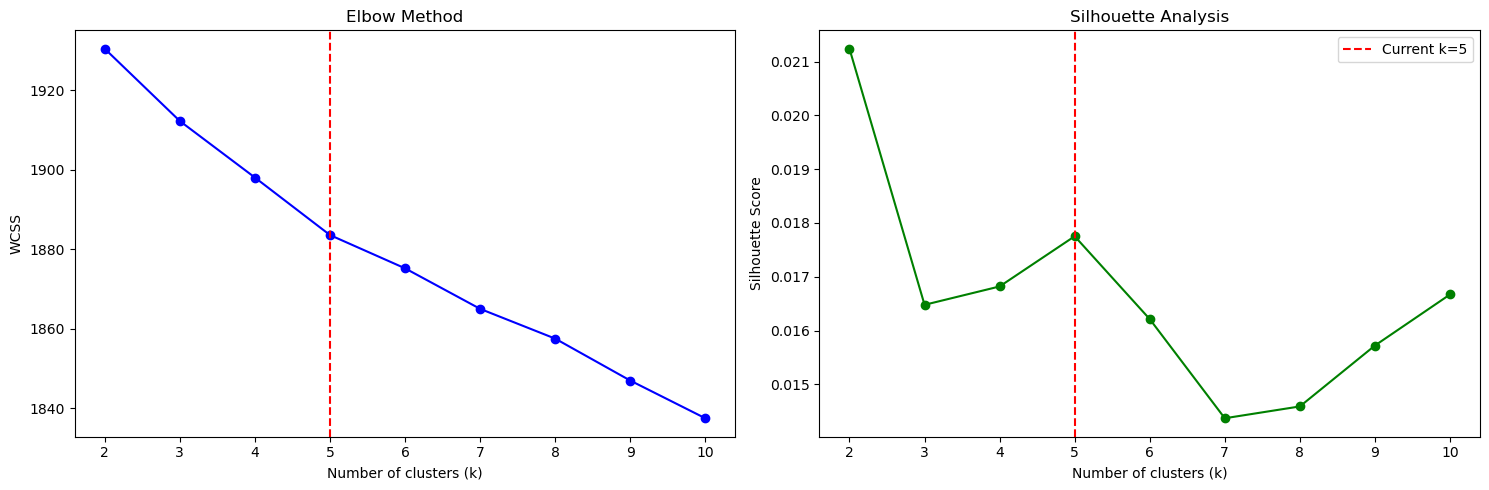

In [20]:
import matplotlib.pyplot as plt

N_CLUSTERS = 5

wcss = [results[k]['wcss'] for k in K_RANGE]
silhouettes = [results[k]['silhouette'] for k in K_RANGE if k > 1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Elbow method plot
ax1.plot(K_RANGE, wcss, 'bo-')
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('WCSS')
ax1.set_title('Elbow Method')
ax1.axvline(x=N_CLUSTERS, color='r', linestyle='--', label=f'Current k={N_CLUSTERS}')

# Silhouette score plot
ax2.plot(K_RANGE, silhouettes, 'go-')
ax2.set_xlabel('Number of clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Analysis')
ax2.axvline(x=N_CLUSTERS, color='r', linestyle='--', label=f'Current k={N_CLUSTERS}')

plt.tight_layout()
plt.legend()
plt.show()

### Evaluation

In [21]:
clusters = results[N_CLUSTERS]['labels']

print(f"Clustering completed with {N_CLUSTERS} clusters")
print(f"Cluster distribution: {np.bincount(clusters)}")

Clustering completed with 5 clusters
Cluster distribution: [ 677  363 1669  564 1227]


In [22]:
cluster_keywords = {}
for i, cluster_id in enumerate(clusters):
    cluster_keywords.setdefault(cluster_id, []).append(keywords[i])

print("Cluster preview:")
print("=" * 50)
for cluster_id in range(N_CLUSTERS):
    words = cluster_keywords.get(cluster_id, [])
    sample = random.sample(words, min(10, len(words))) if words else []
    print(f"\n🏷️ Cluster {cluster_id} ({len(words)} keywords):")
    print(", ".join(sample))

Cluster preview:

🏷️ Cluster 0 (677 keywords):
knowledge graph, Stargate AI, GPTPro, Google AI API, AI-generated code, chatbot, OpenAI embeddings, AI companionship, AI-based code generators, LLama 3

🏷️ Cluster 1 (363 keywords):
Cursor Connections Specification, Bubble Cursor, cursor-swiping, text shaper, context aware completion, textual user interface, screen sharing, scroll events, text-editors, multi-line editing

🏷️ Cluster 2 (1669 keywords):
Powerbook, platform, matches, OHLC, CSV, gemini-2.5-pro, model agnostic, moral code, Zoom, DSP

🏷️ Cluster 3 (564 keywords):
Common Lisp, tensorflow, MySQL, Puppet, Apache, VAX/VMS, Kubernetes, authjs, react-native, FontForge

🏷️ Cluster 4 (1227 keywords):
multi-provider support, network interfaces, hooks architecture, data visualization, product-market fit, sequential scripts, research tool, access control, webhook, stateless design
